In [1]:
import copy
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})
# PyTorch
import torch
import torch.nn as nn
import torchvision

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import models
from posteriors.swag import SWAG
import utils

In [3]:
normalized_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=232),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=232),
    torchvision.transforms.CenterCrop(size=224),
])
normalized_val_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/val/', transform=normalized_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/val/', transform=transform)

In [4]:
checkpoint_path = '/cluster/home/eharve06/understanding-SWAG/experiments/swag_ImageNet_v2_torchvision/swag_epochs=30_K=20_lr=0.01_no_cov_factor=False_random_state=1001.pt'
model = torchvision.models.resnet50()
swag_model = SWAG(model)
swag_model.load(checkpoint_path)

11602 14413


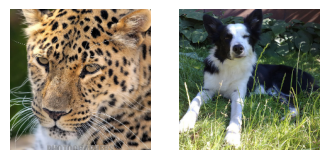

In [11]:
i, j = random.randint(0, len(val_dataset)), random.randint(0, len(val_dataset))
i, j = 11602, 14413
#i, j = 20, 32801
print(i, j)
image_i, label_i = val_dataset[i]
image_j, label_j = val_dataset[j]

ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))
axs[0].imshow(image_j.permute(1, 2, 0))
axs[1].imshow(image_i.permute(1, 2, 0))
for col_i in range(ncols): axs[col_i].axis('off')
plt.show()

In [ ]:
image_i, label_i = normalized_val_dataset[i]
image_j, label_j = normalized_val_dataset[j]
alphas_21 = np.linspace(0, 1, num=21)

swag_all_probas = []
for _ in tqdm(range(100)):
    sampled_params = swag_model.sample()
    torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
    probas = []
    with torch.no_grad():
        for alpha in alphas_21:
            logit = model((alpha*image_i+(1-alpha)*image_j)[None, :, :, :])
            proba = torch.nn.functional.softmax(logit, dim=-1)
            probas.append([proba[0, label_i].item(), proba[0, label_j].item()])
    swag_all_probas.append(probas)

In [25]:
np.save(f'swag_{i}_{j}', swag_all_probas)

In [12]:
random_states = [1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001, 10001]
checkpoint_paths = [f'/cluster/home/eharve06/understanding-SWAG/experiments/ImageNet_v2/ImageNet_v2_random_state={random_state}.pt' for random_state in random_states]
alphas_21 = np.linspace(0, 1, num=21)

ensemble_all_probas = []
for checkpoint_path in checkpoint_paths:
    checkpoint = torch.load(f'{checkpoint_path}', map_location=torch.device('cpu'))['model']
    model.load_state_dict(checkpoint)
    probas = []
    with torch.no_grad():
        for alpha in alphas_21:
            logit = model((alpha*image_i+(1-alpha)*image_j)[None, :, :, :])
            proba = torch.nn.functional.softmax(logit, dim=-1)
            probas.append([proba[0, label_i].item(), proba[0, label_j].item()])
    ensemble_all_probas.append(probas)

In [13]:
np.save(f'ensemble_{i}_{j}', ensemble_all_probas)

In [14]:
with open('imagenet1000_clsidx_to_labels.txt', 'r') as file:
    imagenet1000_clsidx_to_labels = {}
    for line in file:
        index, name = line.strip().split(': ')
        index = int(index.strip('{}'))
        imagenet1000_clsidx_to_labels[index] = name[1:-2]

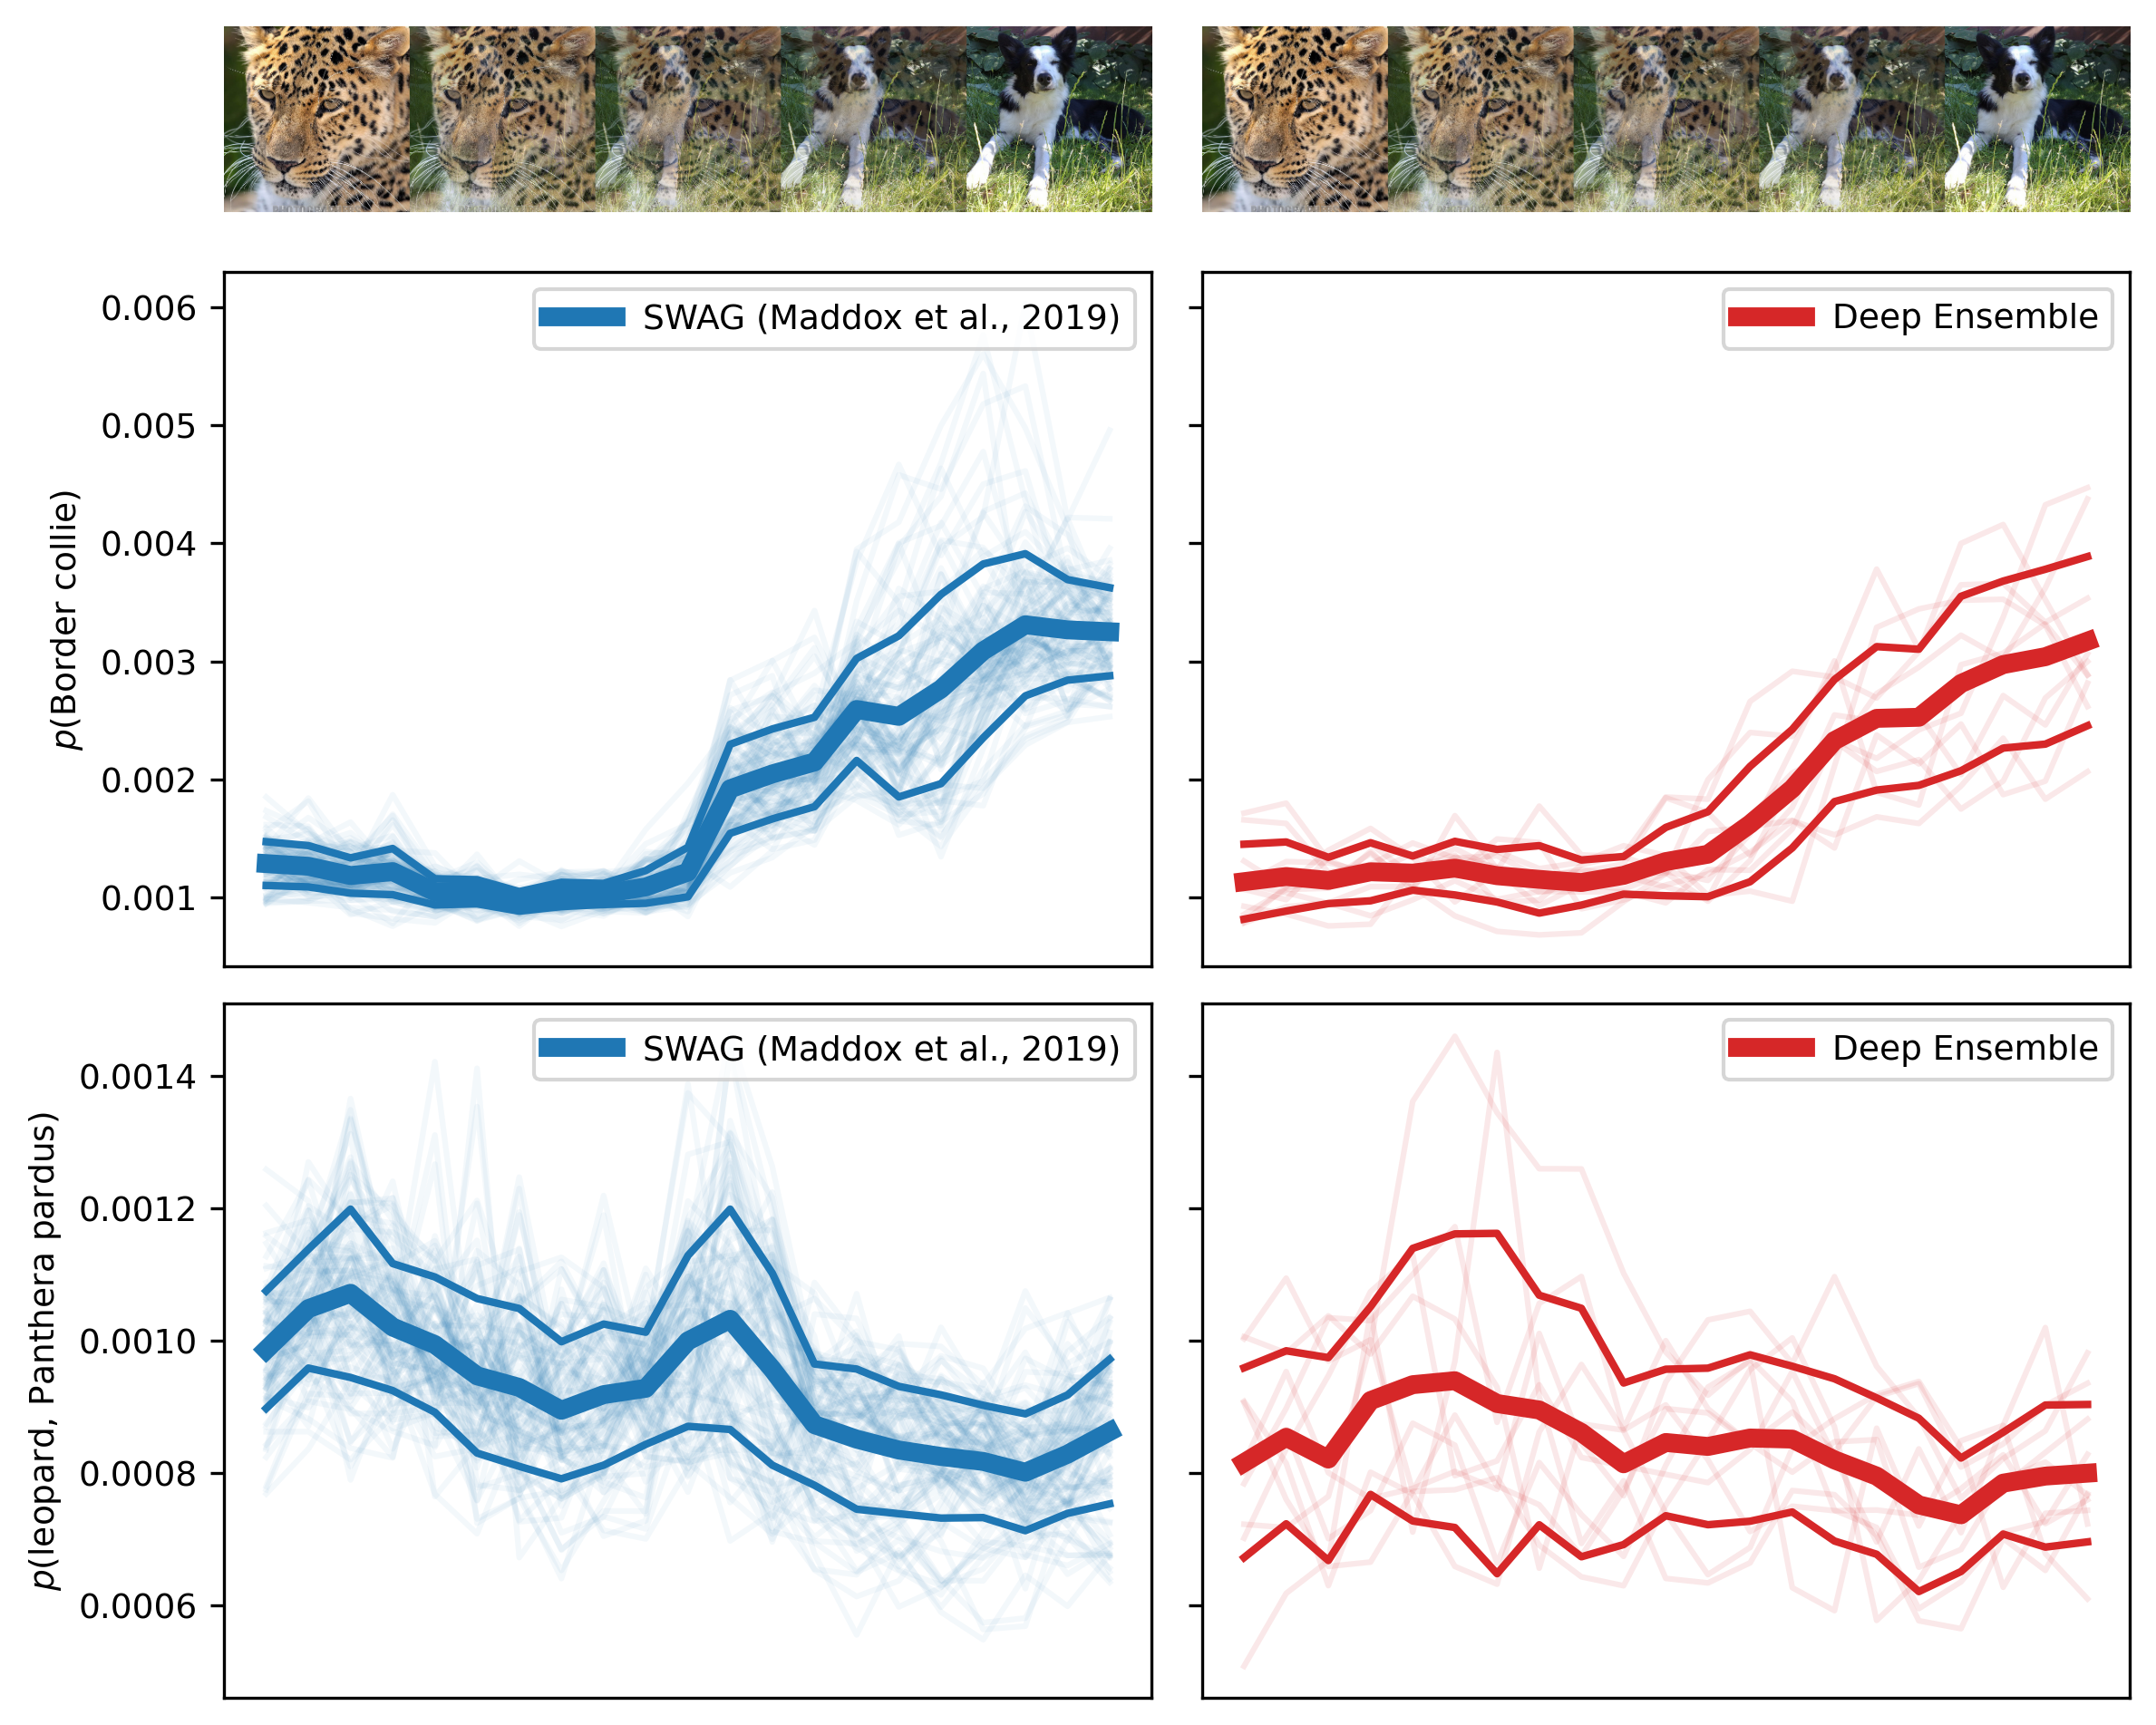

In [15]:
def plot_subplot(axs, i, j):
    
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(size=232),
        torchvision.transforms.CenterCrop(size=224),
    ])
    val_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/val/', transform=transform)

    image_i, label_i = val_dataset[i]
    image_j, label_j = val_dataset[j]
    
    alphas_21 = np.linspace(0, 1, num=21)

    swag_all_probas = np.load(f'swag_{i}_{j}.npy')[:]
    swag_probas_mean = swag_all_probas.mean(axis=0)
    swag_probas_std = swag_all_probas.std(axis=0)
    swag_probas_upper = swag_probas_mean + swag_probas_std
    swag_probas_lower = swag_probas_mean - swag_probas_std

    ensemble_all_probas = np.load(f'ensemble_{i}_{j}.npy')[:]
    ensemble_probas_mean = ensemble_all_probas.mean(axis=0)
    ensemble_probas_std = ensemble_all_probas.std(axis=0)
    ensemble_probas_upper = ensemble_probas_mean + ensemble_probas_std
    ensemble_probas_lower = ensemble_probas_mean - ensemble_probas_std

    axs[0,0].imshow(torch.cat([alpha*image_i.permute(1, 2, 0)+(1-alpha)*image_j.permute(1, 2, 0) for alpha in np.linspace(0, 1, num=5)], dim=1))
    axs[0,0].axis('off')
    axs[0,1].imshow(torch.cat([alpha*image_i.permute(1, 2, 0)+(1-alpha)*image_j.permute(1, 2, 0) for alpha in np.linspace(0, 1, num=5)], dim=1))
    axs[0,1].axis('off')

    axs[1,0].set_ylabel(rf'$p(${imagenet1000_clsidx_to_labels[label_i]}$)$')
    axs[1,1].plot(alphas_21, ensemble_all_probas[:, :, 0].T, alpha=0.1, color='#D62728')
    axs[1,1].plot(alphas_21, ensemble_probas_mean[:, 0], color='#D62728', lw=5, label='Deep Ensemble')
    axs[1,1].plot(alphas_21, ensemble_probas_lower[:, 0], color='#D62728', lw=2)
    axs[1,1].plot(alphas_21, ensemble_probas_upper[:, 0], color='#D62728', lw=2)
    axs[1,1].xaxis.set_visible(False)
    axs[1,1].legend(loc='upper right')

    axs[1,0].plot(alphas_21, swag_all_probas[:, :, 0].T, alpha=0.05, color='#1F77B4')
    axs[1,0].plot(alphas_21, swag_probas_mean[:, 0], color='#1F77B4', lw=5, label='SWAG (Maddox et al., 2019)')
    axs[1,0].plot(alphas_21, swag_probas_lower[:, 0], color='#1F77B4', lw=2)
    axs[1,0].plot(alphas_21, swag_probas_upper[:, 0], color='#1F77B4', lw=2)
    axs[1,0].xaxis.set_visible(False)
    axs[1,0].legend(loc='upper right')

    axs[2,0].set_ylabel(rf'$p(${imagenet1000_clsidx_to_labels[label_j]}$)$')
    axs[2,1].plot(alphas_21, ensemble_all_probas[:, :, 1].T, alpha=0.1, color='#D62728')
    axs[2,1].plot(alphas_21, ensemble_probas_mean[:, 1], color='#D62728', lw=5, label='Deep Ensemble')
    axs[2,1].plot(alphas_21, ensemble_probas_lower[:, 1], color='#D62728', lw=2)
    axs[2,1].plot(alphas_21, ensemble_probas_upper[:, 1], color='#D62728', lw=2)
    axs[2,1].xaxis.set_visible(False)
    axs[2,1].legend(loc='upper right')

    axs[2,0].plot(alphas_21, swag_all_probas[:, :, 1].T, alpha=0.05, color='#1F77B4')
    axs[2,0].plot(alphas_21, swag_probas_mean[:, 1], color='#1F77B4', lw=5, label='SWAG (Maddox et al., 2019)')
    axs[2,0].plot(alphas_21, swag_probas_lower[:, 1], color='#1F77B4', lw=2)
    axs[2,0].plot(alphas_21, swag_probas_upper[:, 1], color='#1F77B4', lw=2)
    axs[2,0].xaxis.set_visible(False)
    axs[2,0].legend(loc='upper right')



ncols, nrows = 2, 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*(nrows-1)+1/2), dpi=300, sharey='row',
                        gridspec_kw={'height_ratios': [1/3, 1, 1]})
i, j = 11602, 14413
#i, j = 20, 32801
plot_subplot(axs, i, j)
fig.tight_layout()
plt.savefig(f'{i}_{j}.pdf', bbox_inches='tight')
plt.show()

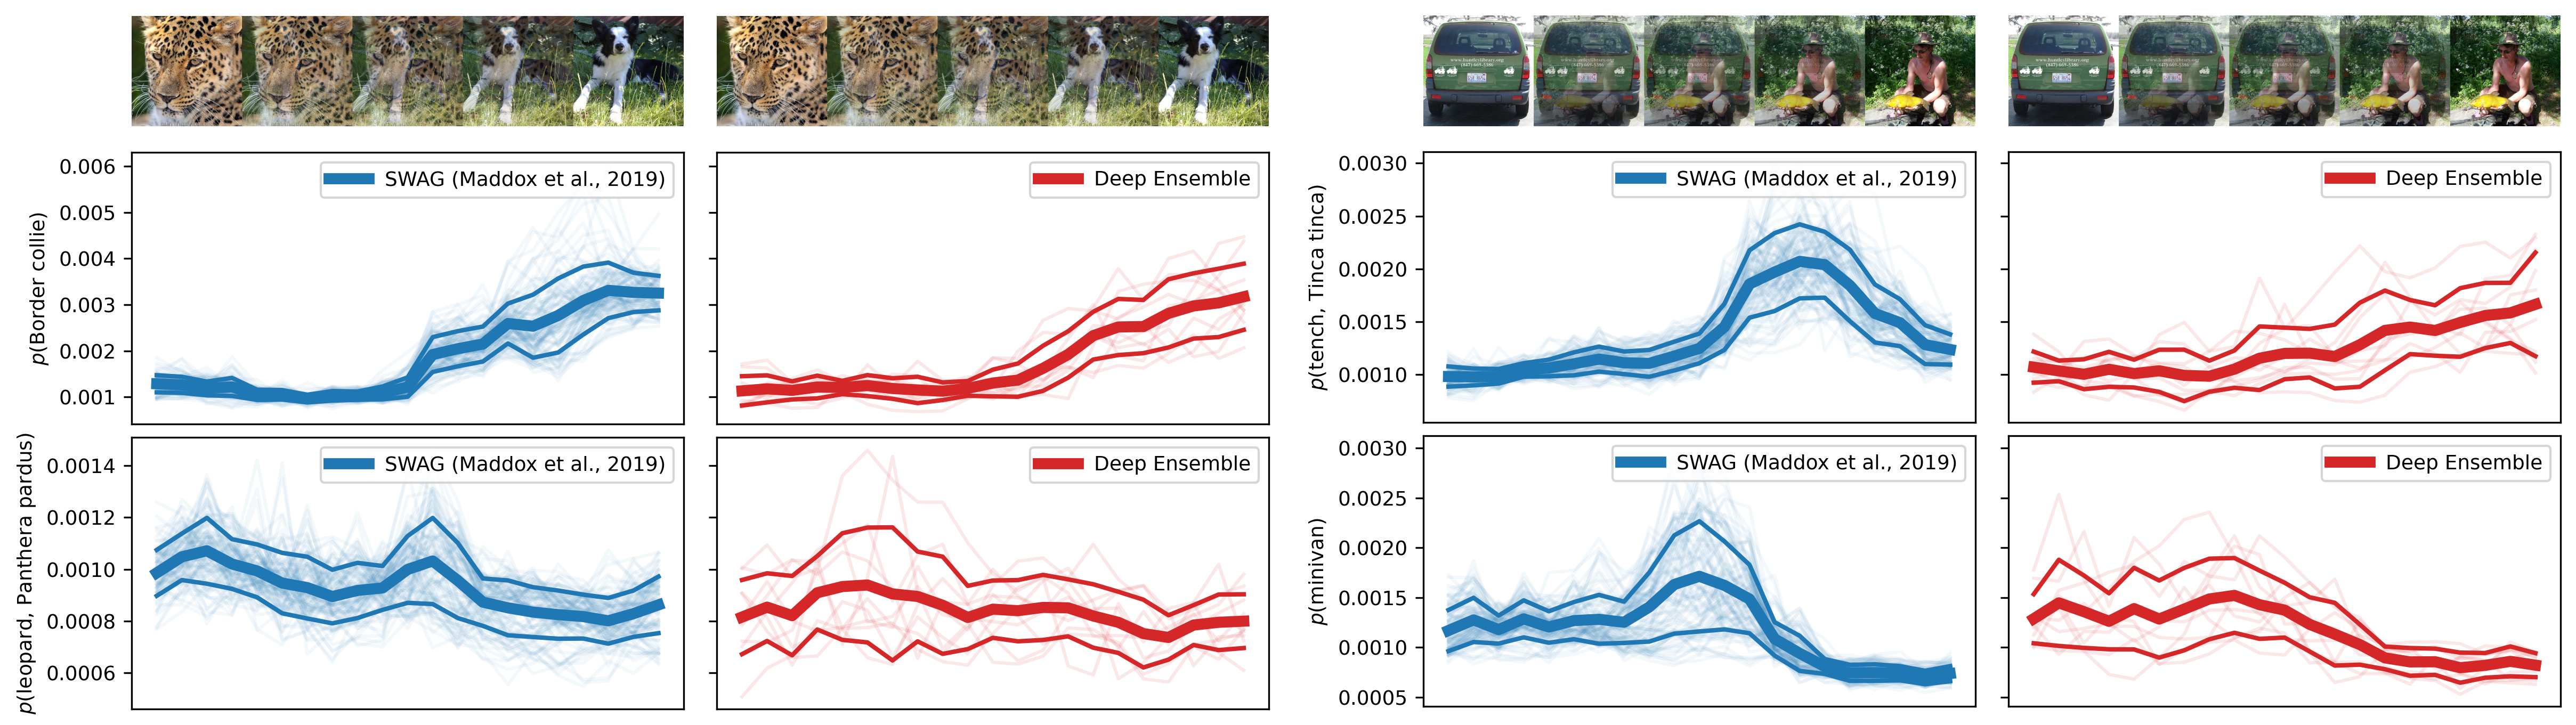

In [16]:
ncols, nrows = 2, 1
fig = plt.figure(figsize=(ncols*8, nrows*9/2), dpi=300, constrained_layout=True)

subfigs = fig.subfigures(ncols=ncols, nrows=nrows)
ijs = [(11602, 14413), (20, 32801)]
for subfig_index, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(ncols=2, nrows=3, sharey='row',
                          gridspec_kw={'height_ratios': [1/2, 1, 1]})
    i, j = ijs[subfig_index]
    plot_subplot(axs, i, j)

plt.savefig(f'predictive_distributions.pdf', bbox_inches='tight')
plt.show()